# MBTA Bus Route 16: Looking at General Trends & Disability Rates by Census Tract

In this extension project, we aimed to explore possible correlations between the MBTA bus service in Boston, MA and displacement. 

We began this project by looking at general ridership trends for buses, including visualizing which stops and neighborhoods have the highest average load and activity and the distribution of load and activity across neighborhoods (see the preliminary <a href = "https://github.com/BU-Spark/ds-livable-streets-infra/blob/team-c-bus-transit-proposal/sp24-team-c/deliverables/bus-mid-semester-proposal/analysis_plots/bus_analysis.ipynb">mid-semester proposal</a> for more).

However, after the mid-semester meeting, we decided to pivot and start looking at a particular bus route, the Columbia Road route 16, per the client's request. We explore general ridership trends of this route (how many people ride this route, when do they ride it, etc.). Additionally, I wanted to see if the Plan for Accessible Transit Infrastructure (<a href="https://www.mbta.com/projects/accessibility-improvements">PATI</a>), which is still in progress, has had any effect on bus ridership and determind if there are any coorelations between disability and displacement.

## Importing Data

Suffolk County Tracts Source: https://www2.census.gov/geo/maps/DC2020/PL20/st25_ma/censustract_maps/c25025_suffolk/DC20CT_C25025.pdf
\
Bus Route 16: https://www.mbta.com/schedules/16/line?schedule_direction%5Bdirection_id%5D=1&schedule_direction%5Bvariant%5D=16-9-1
\
\
Bus route 16 passes through and are in between several tracts: 612.01, 611.01, 907, 913, 912, 914, 915, 903, 918, 902, 901, 9803, 1202.01, 1201.04, 1101.05
\
\
I mostly used 
<a href="https://data.census.gov/table/ACSST5Y2022.S1810?g=1400000US25017339400,25017339500,25017339600,25017339700,25017350107,25017350108,25017350109,25017350201,25017350202,25017350300,25017350400,25017350500,25017350600,25017351001,25017351101,25017351102,25017351203,25017351204,25017351300,25017351403,25017351404,25017351500,25017352101,25017352102,25017352200,25017352700">S1810</a>: Disability Characteristics survey to see any correlations between PATI bus stops, disability rates, and total population.

Additionaly, I used data for <a href="https://mbta-massdot.opendata.arcgis.com/datasets/eec03d901d2e470ebd5758c60d793e8e_0/explore?showTable=true">MBTA Ridership Characteristics</a>, <a href="https://mbta-massdot.opendata.arcgis.com/datasets/24a97982b39f4febb504c9e6cb55879b_0/explore?location=42.359130%2C-71.069726%2C12.56">PATI Bus Stops</a>, and <a href="https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2023&layergroup=Census+Tracts">Census Tract Shapefile</a>.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

df_ridership1 = pd.read_csv("../../../data/bus-data/mbta_bus_route_data/Disaggregate_Bus_Ridership.csv")
df_pati = pd.read_csv("../../../data/bus-data/mbta_bus_route_data/PATI_Bus_Stops.csv")
disability_data = pd.read_csv("../../../data/bus-data/census_tract_data/surveys/s1810/disability.csv")
tracts_gdf = gpd.read_file("../../../data/bus-data/census_tract_data/tl_2020_25_tract/tl_2020_25_tract.shp")

#change to lowercase for consistency
df_ridership1.columns = df_ridership1.columns.str.lower()
df_pati.columns = df_pati.columns.str.lower()
df_ridership1['route_id'] = df_ridership1['route_id'].astype(str)

print("DATASET: df_ridership1")
print(df_ridership1.head())
print()



/var/folders/xm/zvlqxssx0438vv_w32qrlddm0000gn/T/ipykernel_88391/86074580.py:5: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df_ridership1 = pd.read_csv("../../../data/bus-data/mbta_bus_route_data/Disaggregate_Bus_Ridership.csv")


DATASET: df_ridership1
      season route_id route_variant  direction_id trip_start_time  \
0  Fall 2016        1         1-_-0             0        05:34:00   
1  Fall 2016        1         1-_-0             0        05:34:00   
2  Fall 2016        1         1-_-0             0        05:34:00   
3  Fall 2016        1         1-_-0             0        05:34:00   
4  Fall 2016        1         1-_-0             0        05:34:00   

   day_type_id day_type_name                      stop_name  stop_id  \
0  day_type_02      saturday  MASSACHUSETTS AVE @ SIDNEY ST      101   
1  day_type_02      saturday  MASSACHUSETTS AVE @ ST BOTOLP       89   
2  day_type_02      saturday  MASSACHUSETTS AVE @ TREMONT S       87   
3  day_type_02      saturday  MASSACHUSETTS AVE @ TROWBRIDG      108   
4  day_type_02      saturday  MASSACHUSETTS AVE @ WASHINGTO    10590   

   stop_sequence  boardings  alightings  load  sample_size  objectid  
0             19        0.0         1.0   5.0            1

### Cleaning Data 

Cleaning the disability survey data by extracting the tract id, reformatting the data to handle non-numeric values safely, and reducing the table into relevant columns, namely the total population, population with a disability, and the percentage of people with a disability. 

In [4]:
import pandas as pd

def extract_tract_id(col_name):
    if "Census Tract" in col_name:
        start = col_name.find('Census Tract') + len('Census Tract')
        end = col_name.find(';')
        return col_name[start:end].strip()
    return None

def reformat_data_safe(df):
    data = {
        'tract_id': [],
        'total_population': [],
        'population_with_disability': [],
        'percentage_with_disability': []
    }

    for col in df.columns:
        tract_id = extract_tract_id(col)
        if tract_id:
            if 'Total!!Estimate' in col:
                data['tract_id'].extend([tract_id] * len(df))
                # Replace non-numeric values and convert to float
                data['total_population'].extend(
                    pd.to_numeric(df[col].str.replace(',', '').replace('(X)', None), errors='coerce')
                )
            elif 'With a disability!!Estimate' in col:
                data['population_with_disability'].extend(
                    pd.to_numeric(df[col].replace('(X)', None), errors='coerce')
                )
            elif 'Percent with a disability!!Estimate' in col:
                data['percentage_with_disability'].extend(
                    pd.to_numeric(df[col].str.rstrip('%').replace('(X)', None), errors='coerce') / 100.0
                )

    new_df = pd.DataFrame(data)
    return new_df

disability_16 = reformat_data_safe(disability_data)
disability_16.head()


,tract_id,total_population,population_with_disability,percentage_with_disability
0,611.01,2293.0,613.0,0.267
1,611.01,NaN,NaN,NaN
2,611.01,1181.0,398.0,0.337
3,611.01,1112.0,215.0,0.193
4,611.01,NaN,NaN,NaN


### Isolating Route 16

We are isolating the total boardings, load, and stops on route 16 from the total ridership data.

In [5]:
route_16_ridership1 = df_ridership1[df_ridership1['route_id'] == '16']
total_boardings_ridership1 = route_16_ridership1['boardings'].sum()
total_load_ridership1 = route_16_ridership1['load'].sum()
stop_ids = route_16_ridership1['stop_id'].unique()

### Calculating Population Density

Using the census tracts geometry area, we calculated the area to be used to calculate population density (total population/total area).

In [6]:
tracts_gdf = tracts_gdf.to_crs(epsg=32619)
tracts_gdf['area_sq_m'] = tracts_gdf.geometry.area
tracts_gdf['area_sq_km'] = tracts_gdf['area_sq_m'] / 10**6

tracts_w_pop_gdf = tracts_gdf[['NAME', 'area_sq_km', 'area_sq_m']]
# print(tracts_w_pop_gdf.head())

In [7]:
# Drop the NaN values from disability_16 DataFrame
disability_16_clean = disability_16.dropna(subset=['total_population'])

# Merge the population data with the area data on the tract identifier
merged_pop_w_area = pd.merge(disability_16_clean, tracts_gdf, left_on='tract_id', right_on='NAME')

# Calculate population density
# Population density is population divided by area in square kilometers
merged_pop_w_area['population_density'] = merged_pop_w_area['total_population'] / merged_pop_w_area['area_sq_km']

pop_den_by_tract = merged_pop_w_area.groupby('tract_id')['population_density'].mean().reset_index()
#print(pop_den_by_tract[['tract_id', 'population_density']])

## Graphing Data

### Route 16 Utilization Throughout a Day
We first wanted to see how ridership in terms of load and boardings on a average day for route 16 looks like. We decided to create a detailed visualization of how route 16 is utilized throughout the day, highlighting key times when transit services are most in demand.

/var/folders/xm/zvlqxssx0438vv_w32qrlddm0000gn/T/ipykernel_88391/2985321169.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_16_ridership1['trip_start_time'] = route_16_ridership1['trip_start_time'].astype(str).apply(correct_time)
/var/folders/xm/zvlqxssx0438vv_w32qrlddm0000gn/T/ipykernel_88391/2985321169.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  route_16_ridership1['trip_start_time'] = pd.to_datetime(route_16_ridership1['trip_start_time'], format='%H:%M:%S')


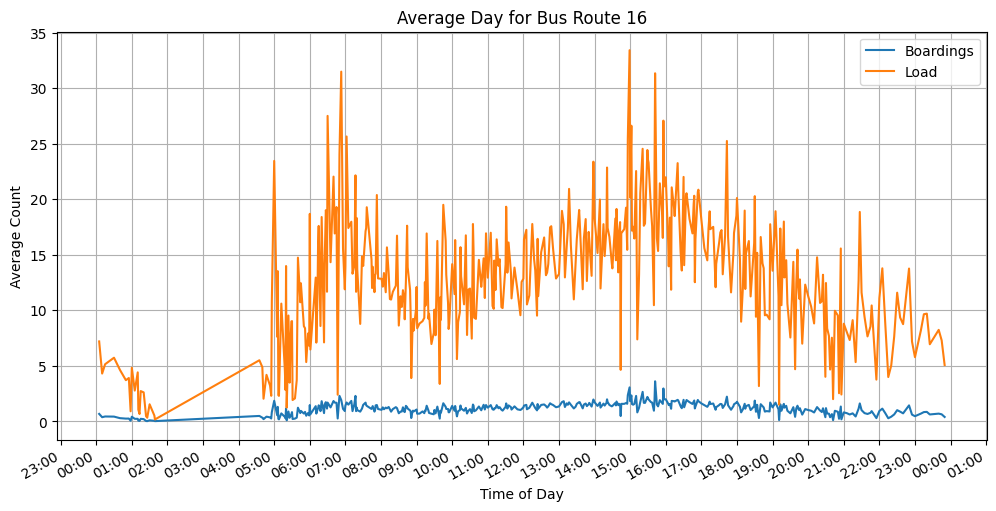

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


# Function to correct invalid hour values
def correct_time(time_str):
    # Split the time string into components
    hours, minutes, seconds = map(int, time_str.split(':'))
    if hours >= 24:
        hours -= 24
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

# Ensure the column is string type and apply the correction
if route_16_ridership1['trip_start_time'].dtype == 'object':
    route_16_ridership1['trip_start_time'] = route_16_ridership1['trip_start_time'].astype(str).apply(correct_time)

# Ensure the trip_start_time is in the correct format
route_16_ridership1['trip_start_time'] = pd.to_datetime(route_16_ridership1['trip_start_time'], format='%H:%M:%S')

# Group data by trip start time and calculate mean boardings and load
average_day = route_16_ridership1.groupby(route_16_ridership1['trip_start_time']).agg({'boardings': 'mean', 'load': 'mean'}).reset_index()

# Plot the data
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(average_day['trip_start_time'], average_day['boardings'], label='Boardings')
ax.plot(average_day['trip_start_time'], average_day['load'], label='Load')
# Use DateFormatter and HourLocator to format the x-axis
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))  
fig.autofmt_xdate()
ax.set_title('Average Day for Bus Route 16')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Average Count')
ax.legend()
ax.grid(True)
plt.show()


The high peaks indicate that the bus is busiest during these times, which again likely corresponds to peak commuting hours. We can see that there are peaks at 0500 (5AM), 0700 (7AM), 1500 (3PM), 1600 (4PM), and smaller peaks at 1745 (5:45PM), and 2130 (9:30PM) for loads.
Additionally, there are peaks around those times for boardings.

However, the average count for loads is much higher than boardings and the peaks do line up which indicates a cumulation of boardings throughout the hour to accumulate a larger load.

This data is crucial to understand demand patterns throughout the day. Knowing when the peak and low demand times occur allows for better allocation of buses to ensure efficient service. For example, additional buses could be scheduled during peak times to handle the increased load and reduce wait times for passengers. This graph largely was made to visualize route 16's usage throughout a typical day to see when people are riding this route.

### PATI Program & Disability Rate Analysis

Next, we wanted to see just how many stops on route 16 is underway for the Plan for Accessible Transit Infrastructure (PATI) program.

The PATI program is part of the MBTA's effort to provide barrier-free access to commuters and increase bus and rail accessibility for passengers with disabilities. It uses innovative collection and database software to analyze conditions to create individual station assessments to set prioritized recommendations.

I decided to plot a simple bargraph showing the counts of the distribution of bus stops among different PATI programs on Route 16, categorized as Unprogrammed, PATI Phase 2, and PATI Phase 1.



/var/folders/xm/zvlqxssx0438vv_w32qrlddm0000gn/T/ipykernel_88391/2039624285.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=program_counts.index, y=program_counts.values, palette='viridis')


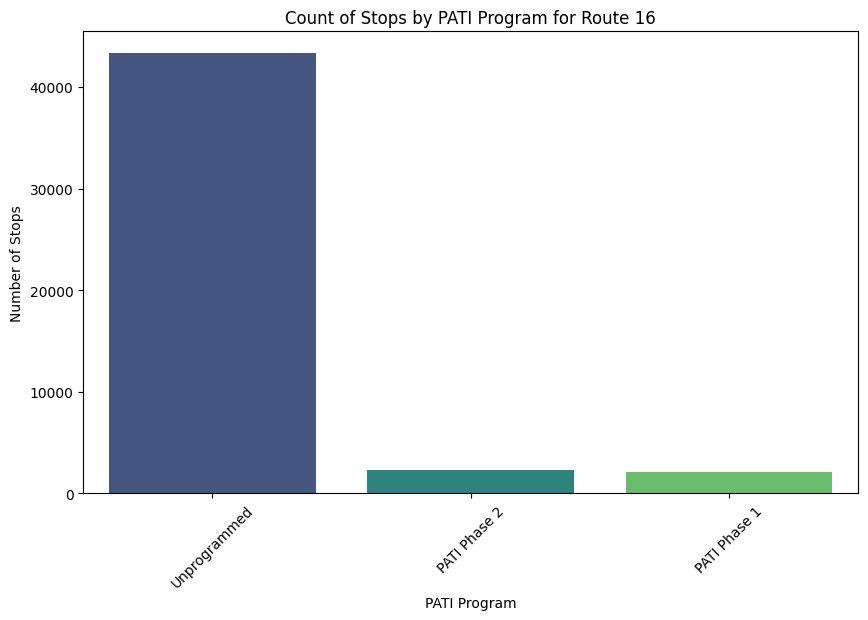

program
Unprogrammed    43297
PATI Phase 2     2342
PATI Phase 1     2074
Name: count, dtype: int64
['CIRCUIT DR OPP SHATTUCK HOSPI' 'COLUMBIA RD @ HOLDEN ST'
 'MT VERNON ST @ BAYSIDE EXPO C' 'COLUMBIA RD @ ANNABEL ST'
 'CIRCUIT DR @ SHATTUCK HOSPITA' 'MT VERNON ST @ BAY SIDE EXPO']


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

route_16_pati_info = pd.merge(route_16_ridership1, df_pati, on='stop_id', how='left')
program_counts = route_16_pati_info['program'].value_counts()

# Plotting the counts
plt.figure(figsize=(10, 6))
sns.barplot(x=program_counts.index, y=program_counts.values, palette='viridis')
plt.title('Count of Stops by PATI Program for Route 16')
plt.xlabel('PATI Program')
plt.ylabel('Number of Stops')
plt.xticks(rotation=45)  
plt.show()

# Filter the DataFrame to get stops that are in PATI Phase 1 or PATI Phase 2
pati_phase_1_2_stops = route_16_pati_info[route_16_pati_info['program'].isin(['PATI Phase 1', 'PATI Phase 2'])]

print(program_counts)
# Stop names from the filtered DataFrame
stop_names_phase_1_2 = pati_phase_1_2_stops['stop_name_x'].unique()
print(stop_names_phase_1_2)


The findings suggest that there are a large number of stops associated with the 'Unprogrammed' category compared to 'PATI Phase 1' and 'PATI Phase 2'. However, upon further investigation, it's observed that there are only six unique stops associated with either 'PATI Phase 1' or 'PATI Phase 2' for route 16. This discrepancy between the large count of stops and the small number of unique stops in the PATI programs may indicate that certain stops are categorized differently or are considered for multiple different routes under the PATI program. 

However, the graph still illustrates the distribution of bus stops among different PATI programs on route 16. It shows that the PATI program is still in the works and the majority of stops are not underway on the program. Next, we want to see how this unporportional distribution affects ridership and areas with varying disability rates.

/Users/nyx/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


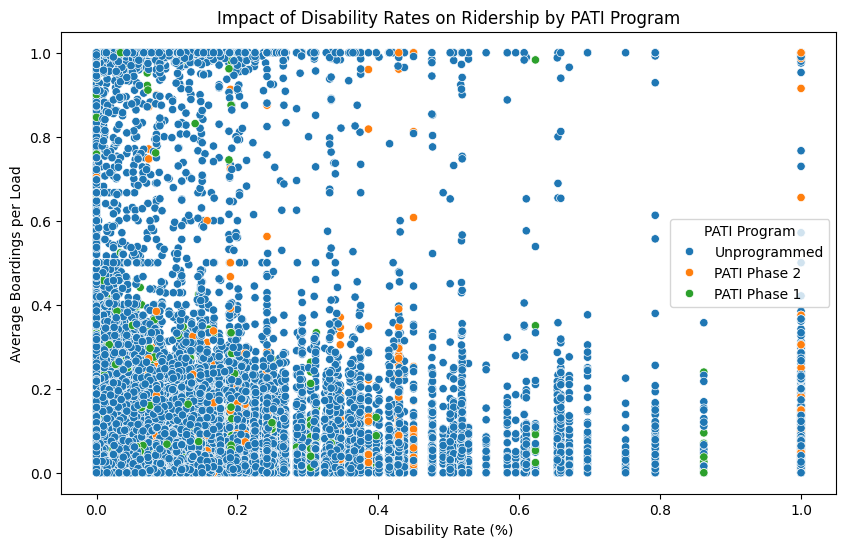

In [10]:
import numpy as np
# Convert stops data to a GeoDataFrame
geometry = [Point(xy) for xy in zip(route_16_pati_info['longitude'], route_16_pati_info['latitude'])]
stops_gdf = gpd.GeoDataFrame(route_16_pati_info, geometry=geometry)
stops_gdf.set_crs(epsg=4269, inplace=True)
# print(tracts_gdf.columns)
# print(tracts_gdf.head(100))
tracts_gdf = tracts_gdf.to_crs(epsg=4269)


mapped_stops = gpd.sjoin(stops_gdf, tracts_gdf, how="left", op='within')
mapped_stops_with_tracts = mapped_stops.merge(disability_16, left_on='NAME', right_on='tract_id', how='left')

#Filter the data to only include rows where 'tract_id' is not NaN, i.e., there is disability data for the tract
filtered_mapped_stops = mapped_stops_with_tracts.dropna(subset=['tract_id'])
filtered_mapped_stops = mapped_stops_with_tracts.dropna(subset=['percentage_with_disability'])

filtered_mapped_stops['average_boardings'] = mapped_stops['boardings'] / mapped_stops['load']

# Create a scatter plot to visualize the relationship between disability rate and average boardings
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_mapped_stops, x='percentage_with_disability', y='average_boardings', hue='program')
plt.title('Impact of Disability Rates on Ridership by PATI Program')
plt.xlabel('Disability Rate (%)')
plt.ylabel('Average Boardings per Load')
plt.legend(title='PATI Program')
plt.show()


The above code is quite messy and hard to read. However, we can see some trends in this. This graph illustrates the spread and distribution of boarding/load ratios in relation to disability rates under different operational programs.
The scatter plot shows individual data points representing the average boardings per load against the disability rate for different segments of the PATI program.
Most of the data points are concentrated at lower disability rates across all categories.
There is a dense clustering of points at low average boardings per load and disability rates, particularly in the "Unprogrammed" category, suggesting that a lower disability rate correlates with lower boarding/load ratios in unstructured settings.
"PATI Phase 1" and "PATI Phase 2" points are more scattered, indicating variability in how these structured programs interact with disability rates.
This suggests that structured PATI phases programs may be better at accommodating or attracting riders with disabilities at varying rates compared to unprogrammed services.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/xm/zvlqxssx0438vv_w32qrlddm0000gn/T/ipykernel_88391/351161332.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = filtered_mapped_stops.groupby(['disability_bin', 'program']).agg({'average_boardings': 'mean'}).reset_index()


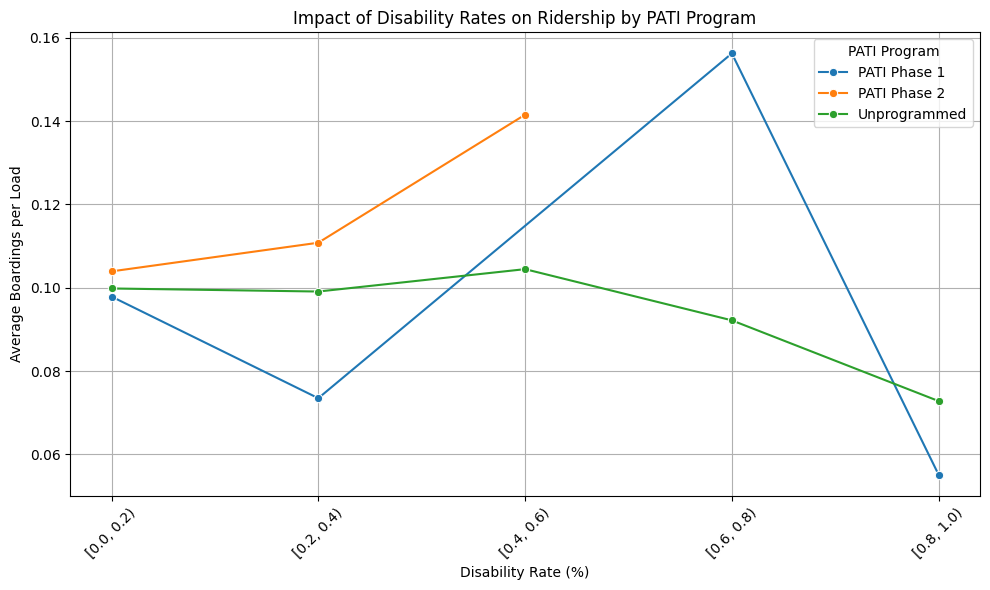

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

bin_edges = np.arange(0, filtered_mapped_stops['percentage_with_disability'].max() + 0.2, 0.2)
# Create a new column to store the bin labels
filtered_mapped_stops['disability_bin'] = pd.cut(filtered_mapped_stops['percentage_with_disability'], bins=bin_edges, right=False)

# Convert 'average_boardings' column to numeric
filtered_mapped_stops['average_boardings'] = pd.to_numeric(filtered_mapped_stops['average_boardings'], errors='coerce')
# Aggregate data within each bin, calculating the mean boarding per load for each PATI program
grouped_data = filtered_mapped_stops.groupby(['disability_bin', 'program']).agg({'average_boardings': 'mean'}).reset_index()
grouped_data['disability_bin'] = grouped_data['disability_bin'].astype(str)

# Plot the grouped data
plt.figure(figsize=(10, 6))
sns.lineplot(data=grouped_data, x='disability_bin', y='average_boardings', hue='program', marker='o')

plt.title('Impact of Disability Rates on Ridership by PATI Program')
plt.xlabel('Disability Rate (%)')
plt.ylabel('Average Boardings per Load')
plt.legend(title='PATI Program')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


I decided to clean the above scatter plot up by aggregating the data into a line plot of the ranges of disability rates, showing a trend line for each PATI program category to demonstrate how structured programming PATI Phases might influence ridership differently in contexts with varying disability rates. "PATI Phase 1" shows an increasing trend in average boardings per load as the disability rate increases, peaking in the 0.6-0.8 range.
"PATI Phase 2" initially shows a decrease in boardings per load as disability rates increase from 0.0-0.2 to 0.2-0.4, then a slight increase before a steep decline in the highest disability range.
The "Unprogrammed" category shows a decrease as disability rates increase, with a significant drop in the highest disability range.

This suggests that "PATI Phase 1" might be seen as increasingly accommodating or attractive to riders as disability rates increase, up to a point.
The stark drops in "PATI Phase 2" and "Unprogrammed" at high disability rates could indicate issues in service accessibility or attractiveness in these settings, suggesting a need for focused improvements in accessibility and support services. This confirms that structured PATI phases programs may be better at accommodating or attracting riders with disabilities at varying rates compared to unprogrammed services with the steep decline in ridership for high disability rate tracts.


### Population Density and Ridership

Next, we wanted to see the effects of population density in correlation to ridership.

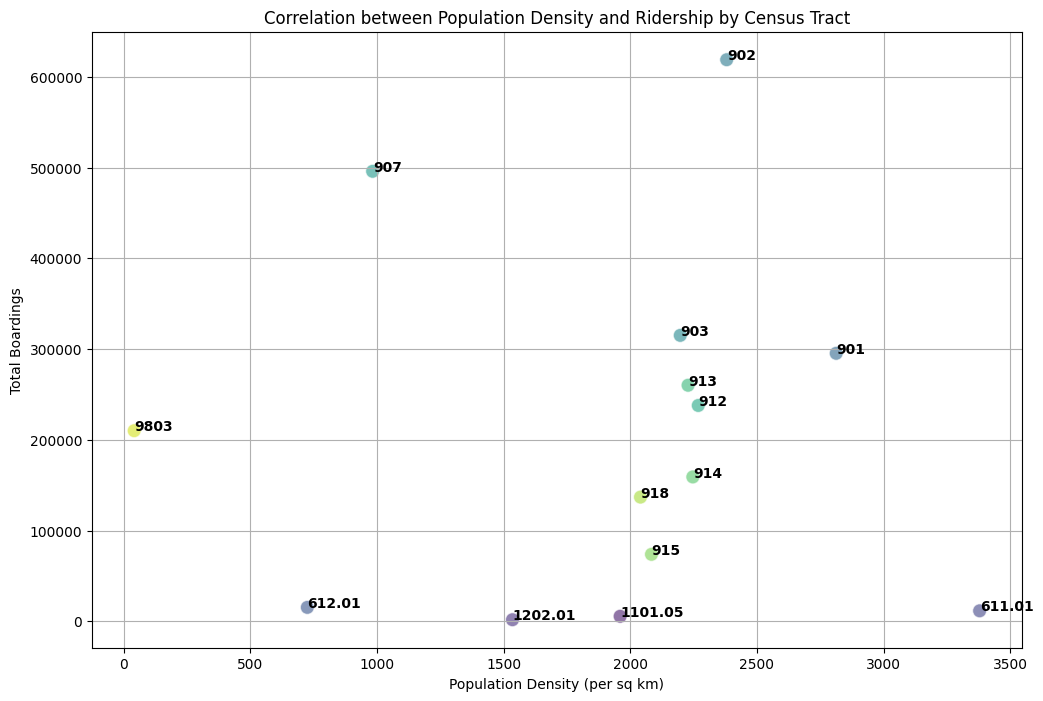

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate the total boardings by census tract
total_boardings_by_tract = mapped_stops_with_tracts.groupby('tract_id')['boardings'].sum().reset_index()

# Merge with the population density data
merged_data = pd.merge(total_boardings_by_tract, pop_den_by_tract, on='tract_id')


plt.figure(figsize=(12, 8))
plot = sns.scatterplot(data=merged_data, x='population_density', y='boardings', hue='tract_id', palette='viridis', s=100, legend=None, alpha=0.6)

for line in range(0, merged_data.shape[0]):
     plot.text(merged_data.population_density[line]+0.5, merged_data.boardings[line], 
     merged_data.tract_id[line], horizontalalignment='left', 
     size='medium', color='black', weight='semibold')

plt.title('Correlation between Population Density and Ridership by Census Tract')
plt.xlabel('Population Density (per sq km)')
plt.ylabel('Total Boardings')
plt.grid(True)
plt.show()


The scatter plot shows a broad spread of data points across various population densities. Each point represents a census tract.

There appears to be a general increase in total boardings as population density increases, especially noticeable in higher density areas (>1500 per sq km). However, there are exceptions, such as some high-density areas with relatively low boardings and some low-density areas with moderate boardings.
The highest total boardings occur at population densities near 2500 per sq km, suggesting a potential hotspot of ridership demand for that particular tract. This visualization helps identify which census tracts, based on population density, contribute most to ridership. It suggests that higher population densities tend to support greater ridership, which is a critical insight for planning service routes and capacities, with the exception of  outliers. This data helps in seeing how to optimize resource allocation for particular tracts, focusing on densely populated areas to improve service efficiency and meet high demand.


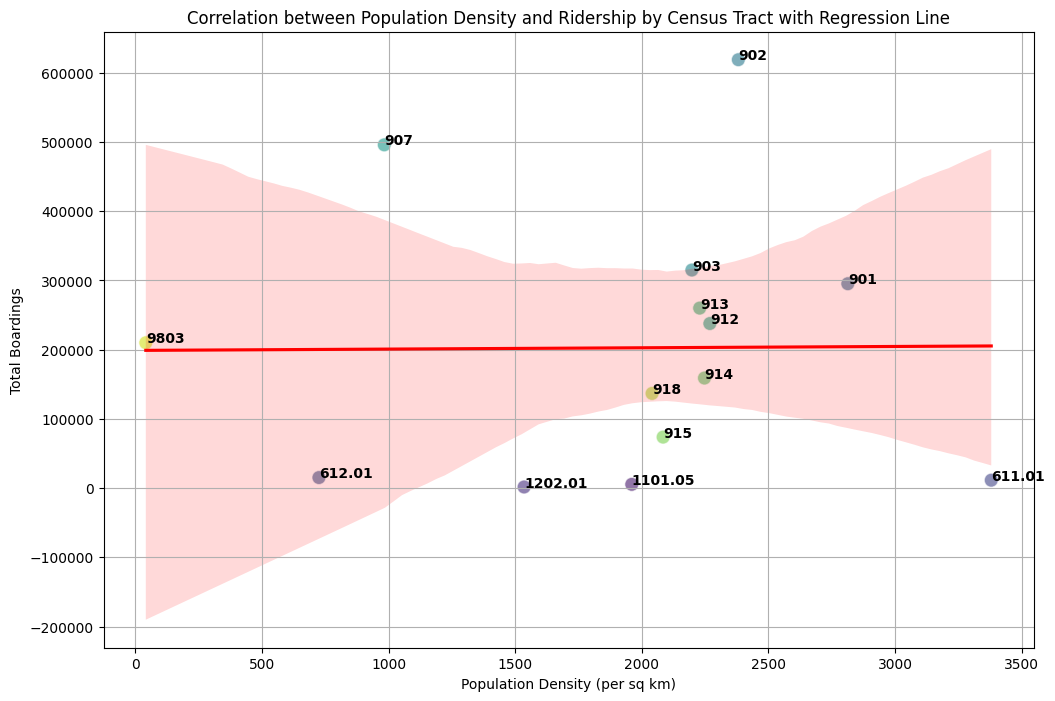

In [13]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

total_boardings_by_tract = mapped_stops_with_tracts.groupby('tract_id')['boardings'].sum().reset_index()

merged_data = pd.merge(total_boardings_by_tract, pop_den_by_tract, on='tract_id')

plt.figure(figsize=(12, 8))

scatter = sns.scatterplot(data=merged_data, x='population_density', y='boardings', hue='tract_id', palette='viridis', s=100, legend=None, alpha=0.6)

sns.regplot(data=merged_data, x='population_density', y='boardings', scatter=False, color='red')

for line in range(0, merged_data.shape[0]):
     scatter.text(merged_data.population_density[line]+0.5, merged_data.boardings[line], 
                  merged_data.tract_id[line], horizontalalignment='left', 
                  size='medium', color='black', weight='semibold')

plt.title('Correlation between Population Density and Ridership by Census Tract with Regression Line')
plt.xlabel('Population Density (per sq km)')
plt.ylabel('Total Boardings')
plt.grid(True)
plt.show()


To try to visualize the correlation better, we decided to perform linear regression on the Correlation between Population Density and Ridership by Census Tract graph with a confidence interval.
The red regression line indicates the overall trend in the data, which suggests that total boardings do not strongly correlate with increasing population density across the census tracts. In fact, the line is relatively flat, indicating little or no strong positive or negative linear relationship. In other words, there seemes to be little to no correlation between population density and ridership for these particular tracts, or overall for route 16.
This is most likely due to a lot of variability, as the red shaded area confrims. The confidence interval for the regression estimate shows that there is significant variability in the boardings across census tracts at similar population densities.
\
There is considerable spread in the data points at higher population densities especially, indicating variations in how population density impacts ridership across different tracts. For example, some tracts with lower to average population densities have relatively high total boardings, such as tracts 907 and 902, indicating that factors other than population density might influence ridership levels. Tracts with very high population densities, like 901 and 903, do not necessarily have the highest boardings, which could suggest inefficiencies or unmet demands in these areas.
\
\
This lack of coorelation suggests that simply increasing population density might not directly increase public transit ridership, emphasizing the need to consider other factors such as transit accessibility, service quality, and socioeconomic variables. The variability in ridership despite similar population densities could indicate areas where public transit is either underutilized or overburdened. This information can help in prioritizing areas for transit development or enhancements to meet actual demand more effectively, especially for particular tracts for route 16.

#### Maps

The above graphs showed were not promising in showing any corelations, so we decided to create maps to better visualize each factor in terms of the census tracts. We looked at disability rate, average boardings, and population density seperately in relationship to the census tracts that route 16 travels through.

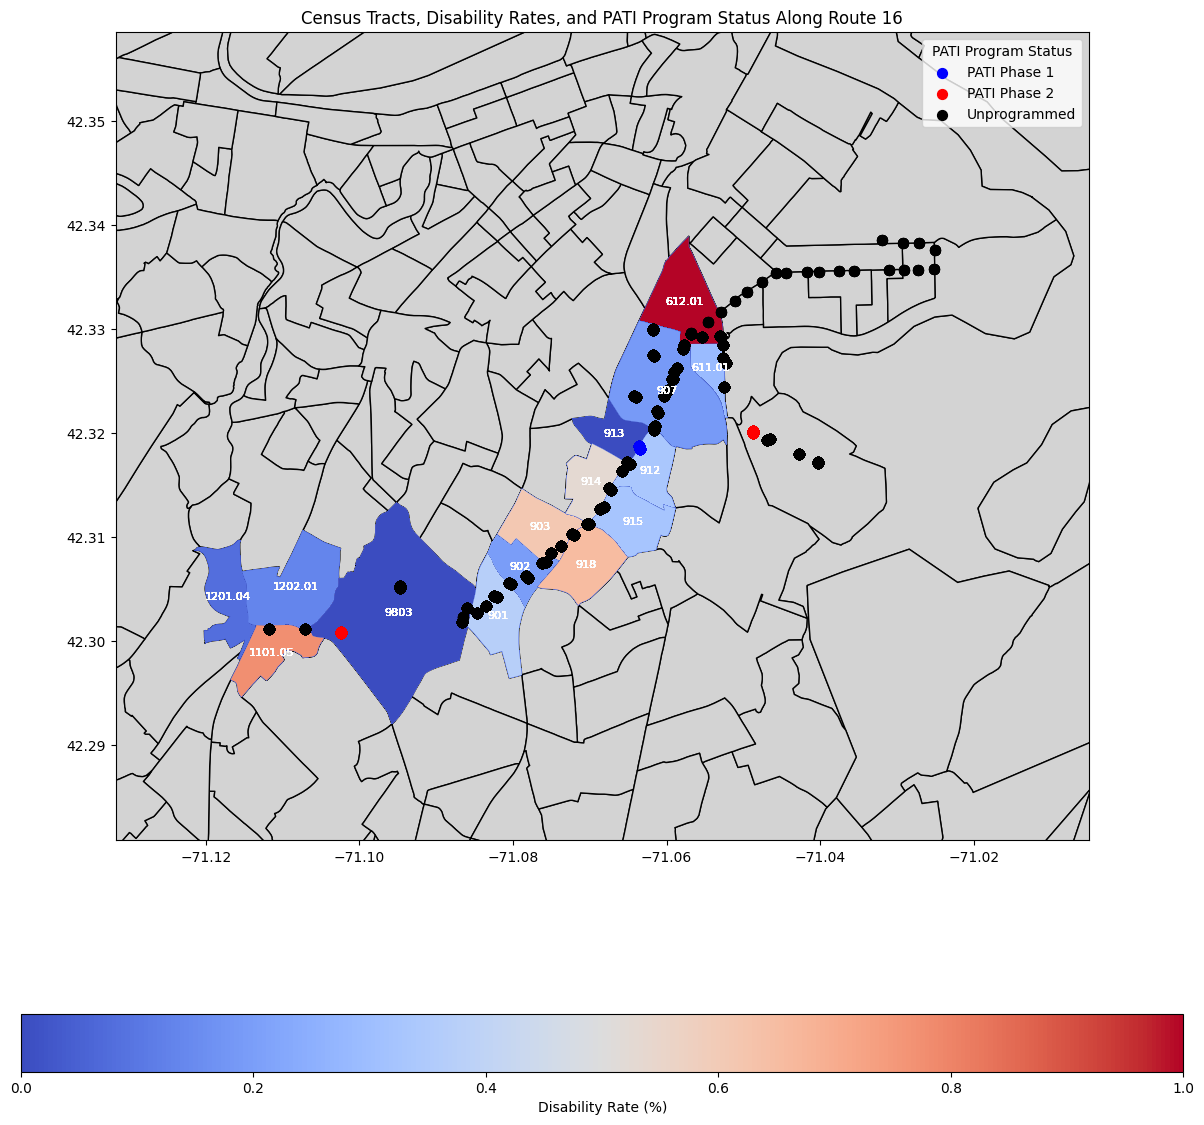

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Calculate the bounding box coordinates with a buffer
buffer = 0.02
minx, miny = route_16_pati_info['longitude'].min() - buffer, route_16_pati_info['latitude'].min() - buffer
maxx, maxy = route_16_pati_info['longitude'].max() + buffer, route_16_pati_info['latitude'].max() + buffer
# Clip the tracts to the bounding box
tracts_within_bbox = tracts_gdf.cx[minx:maxx, miny:maxy]

# Plotting ...
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
tracts_within_bbox.plot(ax=ax, color='lightgrey', edgecolor='black')

merged_tracts = tracts_within_bbox.merge(disability_16, left_on='NAME', right_on='tract_id', how='left')
# merged_tracts.dropna(subset=['percentage_with_disability'])

# Plot tracts with color based on disability rates
merged_tracts.plot(ax=ax, column='percentage_with_disability', cmap='coolwarm', legend=True,
                   legend_kwds={'label': "Disability Rate (%)", 'orientation': "horizontal"})

# Overlay the bus stops, color-coded by PATI program status
pati_colors = {'PATI Phase 1': 'blue', 'PATI Phase 2': 'red', 'Unprogrammed': 'black'}
for program, color in pati_colors.items():
    pati_stops = route_16_pati_info[route_16_pati_info['program'] == program]
    ax.scatter(pati_stops['longitude'], pati_stops['latitude'], c=color, label=program, s=50)  

# Labeling tracts with population density (if not NaN) and setting text color to white
for idx, row in merged_tracts.iterrows():
    if pd.notna(row['percentage_with_disability']):
        ax.annotate(text=row['NAME'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                    ha='center', va='center', fontsize=8, color='white')
    
ax.set_title('Census Tracts, Disability Rates, and PATI Program Status Along Route 16')
ax.legend(title='PATI Program Status')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()


This map displays disability rates by census tract along route 16, 6, with color gradients indicating the disability rates of each tract and PATI program statuses as the stops. The map uses a color gradient from light blue (low disability rate) to deep red (high disability rate) to represent average boarding rates. 
We wanted to see if some areas with higher disability rates might coincide with specific PATI phases, suggesting targeted service provision.
There does not seem to be a strong correlation between disability rates of tracts and the stops where PATI programs are implemented. 
\
\
Note: There are certain tracts not displayed as they are not included in the disability survey csv.

/Users/nyx/Library/Python/3.10/lib/python/site-packages/IPython/core/interactiveshell.py:3318: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


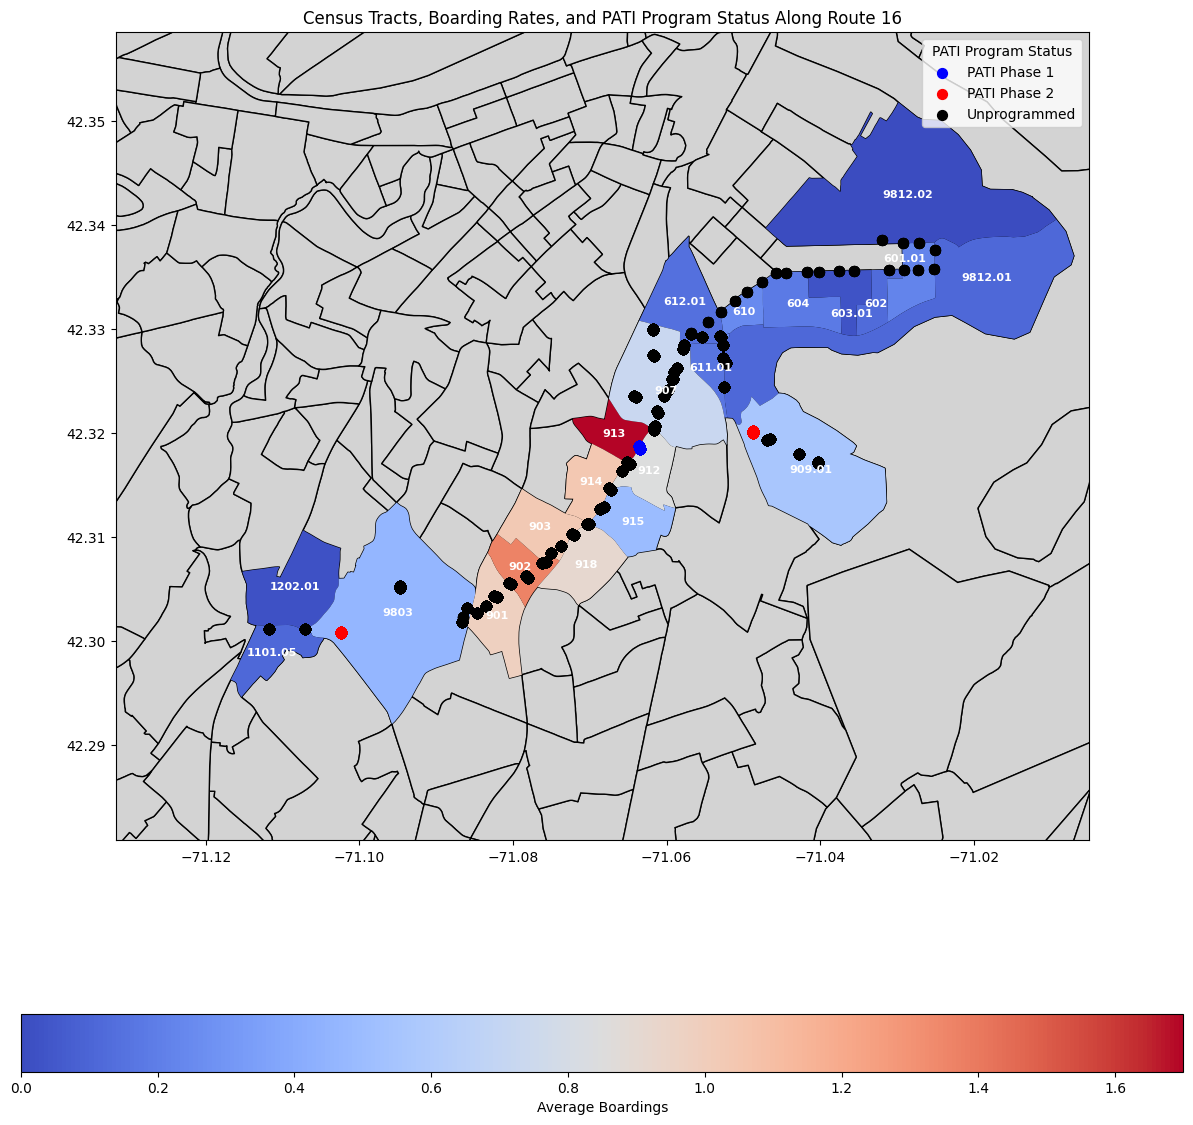

In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

# Group the boarding data by tracts after spatially joining with the tracts GeoDataFrame
stops_gdf = gpd.GeoDataFrame(route_16_pati_info, geometry=gpd.points_from_xy(route_16_pati_info.longitude, route_16_pati_info.latitude))
stops_gdf.set_crs(epsg=4269, inplace=True)

# Spatial join between stops and tracts
mapped_stops = gpd.sjoin(stops_gdf, tracts_gdf, how="left", op='within')
tract_boardings = mapped_stops.groupby('NAME').agg({'boardings': 'mean'}).reset_index()

# Join the average boarding rates with the tracts DataFrame
tracts_with_boardings = tracts_gdf.merge(tract_boardings, left_on='NAME', right_on='NAME', how='left')

buffer = 0.02
minx, miny = route_16_pati_info['longitude'].min() - buffer, route_16_pati_info['latitude'].min() - buffer
maxx, maxy = route_16_pati_info['longitude'].max() + buffer, route_16_pati_info['latitude'].max() + buffer

tracts_within_bbox = tracts_with_boardings.cx[minx:maxx, miny:maxy]


fig, ax = plt.subplots(1, 1, figsize=(15, 15))
tracts_within_bbox.plot(ax=ax, color='lightgrey', edgecolor='black')

# Plot tracts with color based on boarding rates
tracts_within_bbox.plot(ax=ax, column='boardings', cmap='coolwarm', legend=True,
                        legend_kwds={'label': "Average Boardings", 'orientation': "horizontal"})

# Overlay the bus stops, color-coded by PATI program status
pati_colors = {'PATI Phase 1': 'blue', 'PATI Phase 2': 'red', 'Unprogrammed': 'black'}
for program, color in pati_colors.items():
    pati_stops = route_16_pati_info[route_16_pati_info['program'] == program]
    ax.scatter(pati_stops['longitude'], pati_stops['latitude'], color=color, label=program, s=50)

# for idx, row in tracts_within_bbox.iterrows():
#     if pd.notna(row['boardings']):
#         ax.annotate(text=row['NAME'], xy=(row.geometry.centroid.x, row.geometry.centroid.y ), 
#                     horizontalalignment='center', verticalalignment='center', 
#                     fontsize=12, color='white', weight='bold')


label_offsets = {
    '9812.01': (0.009, 0.003),  
    '603.01': (0.001, -0.002),
    '601.01': (-0.001, 0.002),
    '602': (0 ,-0.0001)
}

# Label all tracts, adjusting specific ones as needed
for idx, row in tracts_within_bbox.iterrows():
    if pd.notna(row['boardings']):  # Assuming 'boardings' is your data column
        # Check if the current tract needs a custom offset
        if row['NAME'] in label_offsets:
            offset = label_offsets[row['NAME']]
            x, y = row.geometry.centroid.x + offset[0], row.geometry.centroid.y + offset[1]
        else:
            x, y = row.geometry.centroid.x, row.geometry.centroid.y
        
        ax.annotate(text=row['NAME'], xy=(x, y), 
                    horizontalalignment='center', verticalalignment='center', 
                    fontsize=8, color='white', weight='bold')



ax.set_title('Census Tracts, Boarding Rates, and PATI Program Status Along Route 16')
ax.legend(title='PATI Program Status')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()




Similarly, this map links boarding rates to census tracts along route 16, with color gradients indicating the level of boarding activity and PATI program statuses. The map uses a color gradient from light blue (low boardings) to deep red (high boardings) to represent average boarding rates. 
The color intensity varies significantly across tracts, suggesting substantial differences in boarding rates across the tracts, which illustrates that with some tracts experiencing significantly higher usage compared to others.

Higher boarding rates are particularly notable in tracts colored in deeper shades of red, suggesting these areas are critical transit hubs or have higher residential or commercial activity. Most significantly, tract 913 has the highest average boardings than the other tracts along the route. This tract also is along a stop with a PATI program underway.


The effectiveness of PATI programs can be assessed by comparing boarding rates in programmed vs. unprogrammed tracts. The programmed tracts (Phase 1 and Phase 2) show varied boarding rates than unprogrammed ones. For example, tract 9803 has a relatively medium average boarding with a PATI phase 2 stop, showing that the PATI program does not have obvious correlations with ridership. 

Note: The tracts that are shown here but unavailable to the other graphs are included because they are in both the tracts_gdf and stops_gdf. However, they will not be considered for cross analysis with the other graphs since the data is missing from those graphs.

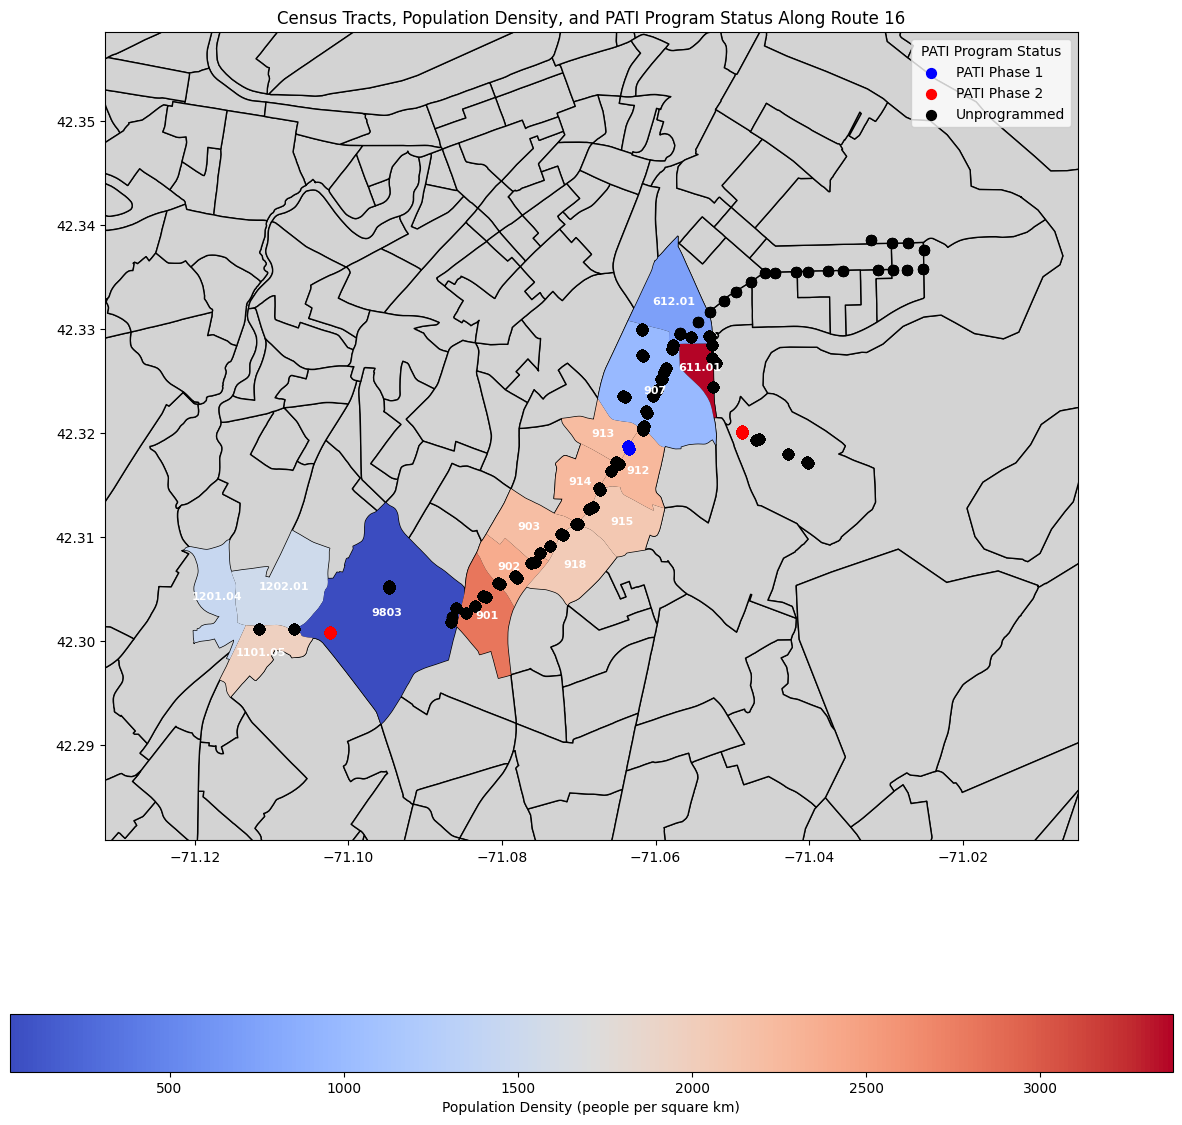

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

# Set up a buffer and bounding box as before
buffer = 0.02
minx, miny = route_16_pati_info['longitude'].min() - buffer, route_16_pati_info['latitude'].min() - buffer
maxx, maxy = route_16_pati_info['longitude'].max() + buffer, route_16_pati_info['latitude'].max() + buffer

tracts_within_bbox = tracts_with_boardings.cx[minx:maxx, miny:maxy]

fig, ax = plt.subplots(1, 1, figsize=(15, 15))
tracts_within_bbox.plot(ax=ax, color='lightgrey', edgecolor='black')

# Merge population density data with tract geometry data
tracts_with_pop_density = tracts_within_bbox.merge(pop_den_by_tract, left_on='NAME', right_on='tract_id', how='left')

# Plotting the tracts with population density
tracts_with_pop_density.plot(ax=ax, column='population_density', cmap='coolwarm', legend=True,
                             legend_kwds={'label': "Population Density (people per square km)", 'orientation': "horizontal"})

# Adding scatter points for PATI program status
for program, color in pati_colors.items():
    pati_stops = route_16_pati_info[route_16_pati_info['program'] == program]
    ax.scatter(pati_stops['longitude'], pati_stops['latitude'], c=color, label=program, s=50)

# Labeling tracts with population density (if not NaN) and setting text color to white
for idx, row in tracts_with_pop_density.iterrows():
    if pd.notna(row['population_density']):
        ax.annotate(text=row['NAME'], xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
                    ha='center', va='center', fontsize=8, color='white', fontweight='bold')

ax.set_title('Census Tracts, Population Density, and PATI Program Status Along Route 16')
ax.legend(title='PATI Program Status')
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)
plt.show()


Similarly, this map shows the population density and PATI program status of different census tracts along route 16. Tracts are color-coded based on population density, with darker colors indicating lower densities. Specific bus stops in route 16 are marked for their participation in PATI Phase 1, Phase 2, or those unprogrammed, indicated by different colored stops. Again, there is a lot of variation across the tracts. We can see that the tracts with PATI Phase 1 and Phase 2 are also centered around varied-density areas (with some near higher densities and some near lower densities), suggesting that the program phases are seemingly untargeted in terms of population density. 

Note: There are certain tracts not displayed as they are not included in the disability survey csv that was used to calculate the total population.

Comparing and contrasting these graphs cross-analytically shows more valuable insights than analyzing them alone.

We can see some correlation between the map for average boardings and the map with population density, with similar tracts, namely 9803 (which is a greenway) being both low in population density and disability rates but not being on the very low end for boardings. This indicates that people are still boarding that stop fairly frequently considering that there are little to no people living in that tract (which would be intuitive with there being little to no people with disabilities living there since there are not a lot of people inhabiting that tract anyways). This can be due to people migrating from neighboring tracts. Namely, people may be moving from tract 1101.05, which has a relatively high disability rate to access the PATI accessible bus stop.


Additionally, we can see tract 913 has very high boardings but relatively average population density meaning that tract 913 is a transit hub area or a tract that contains people who need, prefer, or have greater access to public transportation. Although the three graphs do not show strong correlations in terms of disability rates, average boardings, and population density (in relation to each other and in relation to the PATI program's efforts on their own), there are stories and finding that can be found within the graphs when we cross analyze them.

This marks the end of this particular branch of insight for Livable Streets Team C. Hopefully these observations are useful in deciding what to do next regarding buses in Boston and they can be extended to other routes or other cities! Thank you for reading :)